# The Stochastic Neoclassical Growth Model

## Intro and Setup

In this problem set we will solve 

$$ \begin{align}
V(k,z) &= \max_{0\leq k'\leq e^z f(k)} u(e^z f(k) - k') + \beta E[V(k',z')] \\
u(c) &= \ln c \\
f(k) &= Ak^\alpha \\
\end{align}
$$

This formulation admits a closed form solution to the optimal policy, given by $k' = e^z \alpha \beta A k^\alpha$. 

We assume that the productivity shock is distributed $z\sim N(0,\sigma^2)$.

* Approximate the continuous state space $(k,z)$ by two grids $K={k_1,k_2,\dots,k_n},Z={z_1,\dots,z_m}$. Given the grid $Z$, let $q_j$ represent $\Pr(z=z_j)$, i.e. the probability mass function of our discrete approximation to $z \sim N(0,\sigma^2).$
* Under those assumptions, the discretized Bellman Equation is given by 

$$ V(k_i,z_j) = \max_{i'=1,2,\dots,n} u(\exp{z_j} f(k_i) - k_{i'}) + \beta \sum_{j'=1}^m q_j V(i',j') $$

* Notice that we are just choosing next period's index for $k'$ in the grid $K$, denoted $i'$.
* We will represent $V(k,z)$ by an $(n,m)$ matrix.
* We are constraining the choice variable $k'$ in $V$ to be on the grid of capital as well.
* Set the following parameter values:

| Parameter | Value |
|----------| -------|
|$\beta$| 0.96 |
|$\alpha$| 0.96 |
|$A $| $\frac{1}{\alpha \beta}$ |
|$n$| 55 |
|$m$| 51 |
|$k_1$| 0.08 |
|$k_n$| 3.8 |
|$\sigma$| 0.5 |
|`tol`| 1e-6 |

   where `tol` is a tolerance level for convergence.


* We will approximate the normal shock $z$ at an equi-spaced grid $Z={z_1,\dots,z_m}$, between $-3\sigma$ and $3\sigma$. We can create an equispaced grid with the `linspace` function (do `?linspace` to find out how it works), and we will approximate the normal distribution by

    $$ q_j = \frac{\phi(z_j)}{\sum_{k=1}^m \phi(z_k)} $$
 
    where $\phi$ is the pdf of $z \sim N(0,\sigma^2)$. We divide by this denomiator in order to make sure that the probabilities sum to one. You should use the `Distributions` package to get the Normal distribution. You would do
    ```julia
    Pkg.add("Distributions")
    using Distributions
    norm = Normal(0,sigma)    # create a normal dist with mean 0 and standard dev sigma
    ```
    and you could then easily get the pdf of this distribution with the function `pdf`. Again, do `?pdf` to find out how exactly what works.
* Plot the result of this approximation exercise, i.e. plot $z_j$ vs $q_j$, as well as $\exp(z_j)$ vs $q_j$

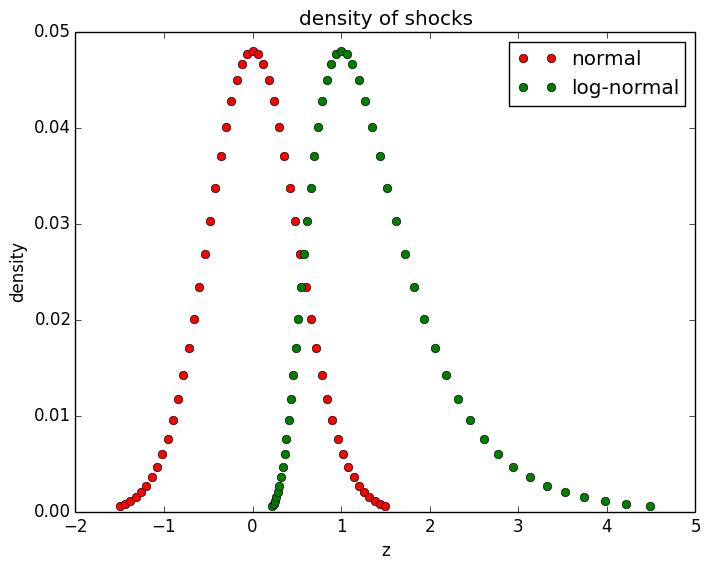

PyObject <matplotlib.legend.Legend object at 0x31c518cd0>

In [2]:
# parameters
alpha = 0.25
beta  = 0.96
A = (alpha*beta)^(-1)   # ss capital level of 1
sigma = 0.5
# numerical parameters
n = 55     # k grid points
m = 51     # z grid points
N = 100    # max number of iterations in value function iteration
tol = 1e-6 # tolerance on value function loop
k_low = 0.08
k_high = 3.8
# grids
kgrid = linspace(k_low,k_high,n)
f(k) = A.*k.^alpha   # production function

# for the z grid we load a package:
using Distributions
zdist = Normal(0,sigma)  # create a Normal distribution called zdist
zgrid = linspace(-3*sigma,3*sigma,m)
q = pdf(zdist,zgrid) / sum(pdf(zdist,zgrid));

# plot this distribution to check
using PyPlot
plot(zgrid,q,"or",label="normal")
xlabel("z")
ylabel("density")
title("density of shocks")

# the actual values of z are log normal:
# just add that to this plot
plot(exp(zgrid),q,"og",label="log-normal")
legend()

## A first implementation

Write Julia code to numerically solve this problem using value function iteration, discretizing both state and control space.

1. Set an initial guess $V^0 = $ `zeros(n,m)`.
2. Given current iteration $r$, compute the next iteration from 

    $$ V^{r+1}(k_i,z_j) = \max_{i'=1,2,\dots,n} u(\exp{z_j} f(k_i) - k_{i'}) + \beta \sum_{j'=1}^m q_j V^r(i',j') $$

3. One way to do this is to write two nested loops. The outer loop is over all values of $k_i$ and $z_j$, the inner one is over next period  $k_{i'}$. There is a useful function `enumerate`, which you may use. (type `?enumerate` to see what it does).
4. Using the current guess $V^r$, compute the part $\sum_{j'=1}^m q_j V^r(i',j')$ as a simple matrix multiplication. Remember that $V^r$ is indexed by `(k,z)`. Multiplying $V^r$ by the vector $q$ therefore represents exatly that sum.
    ```julia
    EV = V0 * q   # (n,m) * (m,1) = (n,1)
    ```
5. Using an auxiliary vector `w=zeros(n)`, the double loop structure could look something like
    ```julia
    #looping over k
        #looping over z
            #looping over all choices k'
                # computing implied V at that (k,z,k') combination
                # and store in w
            # take the max over w (findmax)
            # store max(w) in v(k,z)
        #
    #
    ```
6. you need to be careful to avoid negative consumption values for some choices of $k'$. An easy way to do this is include an `if` statement like 
    ```julia
    cons = exp(z)*f(k) - kprime
    if cons < 0
        w[iprime] = -Inf
    else
        w[iprime] = log(exp(z)*f(k) - kprime) + beta * EV[iprime]
    end
    ```
    this assigns a very low value to negative consumption, thereby preventing this from being the optimal choice.
    
7. Using functions `bellman_operator` and `VFI` as in class, or directly in the console, perform value function iteration to find $V$. Make sure to include a test after each iteration to check whether you've converged. This could look something like

    ```julia
    if maxabs(V0.-V1) < tol
        println("Found solution after $iter iterations")
        break
    end
    ```
    
8. You may find the function `findmax` useful. it returns the maximium value and it's position in an array.
9. Notice that the policy function will return an optimal *index* of capital, not an optimal capital level (i.e. it will return an integer in $K$).

In [3]:
# directly in the console
V0 = zeros(n,m)     # current guess
V1 = zeros(n,m)     # next guess
P  = zeros(Int,n,m)  # policy function
w  = zeros(n)   # temporary vector 
EV = zeros(n,1) # expected value function

# start the VFI loop
for iter in 1:N
    
    # compute expected value of previous guess
    EV = V0 * q   # (n,m) * (m,1) = (n,1)

    
    # loop over current states
    # current capital
    for (i,k) in enumerate(kgrid)
        # current technology z
        for (j,z) in enumerate(zgrid)
            
            # loop over all possible kprime choices
            for (iprime,kprime) in enumerate(kgrid)
                if exp(z)*f(k) - kprime < 0   #check for negative consumption
                    w[iprime] = -Inf
                else
                    w[iprime] = log(exp(z)*f(k) - kprime) + beta * EV[iprime]
                end
            end
            # find maximal choice
            V1[i,j], P[i,j] = findmax(w)     # stores Value und policy (index of optimal choice)
        end
    end
    # check convergence
    if maxabs(V0.-V1) < tol
        println("Found solution after $iter iterations")
        break
    end
    V0 = V1  # update guess
end

# or defining a bellman operator and a VFI function
function bellman_operator(grid1,grid2,v0)
    # compute expected value of previous guess
    EV = v0 * q   # (n,m) * (m,1) = (n,1)
    
    V1 = zeros(n,m)     # next guess
    w  = zeros(n)   # temporary vector 

    # loop over current states
    # current capital
    for (i,k) in enumerate(grid1)
        # current technology z
        for (j,z) in enumerate(grid2)
            
            # loop over all possible kprime choices
            for (iprime,kprime) in enumerate(grid1)
                if exp(z)*f(k) - kprime < 0   #check for negative consumption
                    w[iprime] = -Inf
                else
                    w[iprime] = log(exp(z)*f(k) - kprime) + beta * EV[iprime]
                end
            end
            # find maximal choice
            V1[i,j], P[i,j] = findmax(w)     # stores Value und policy (index of optimal choice)
        end
    end
    return (V1,P)   # return both value and policy function
end

function VFI()
    v_init = zeros(n,m)     # initial guess
    for iter in 1:N
        V1 = bellman_operator(kgrid,zgrid,v_init)  # returns a tuple: (V1,P)
        # check convergence
        if maxabs(v_init.-V1[1]) < tol
            println("Found solution after $iter iterations")
            break
        elseif iter==N
            warn("No solution found after $iter iterations")
        end
        v_init = V1[1]  # update guess (index one is the value function)
    end
    return V1
end

Found solution after 2 iterations


VFI (generic function with 1 method)

## Plot the results

* Plot the value function for all levels of the z shock. (In PyPlot, doing `plot(x,V)` where `V` is a matrix automatically plots each column as a separate line)

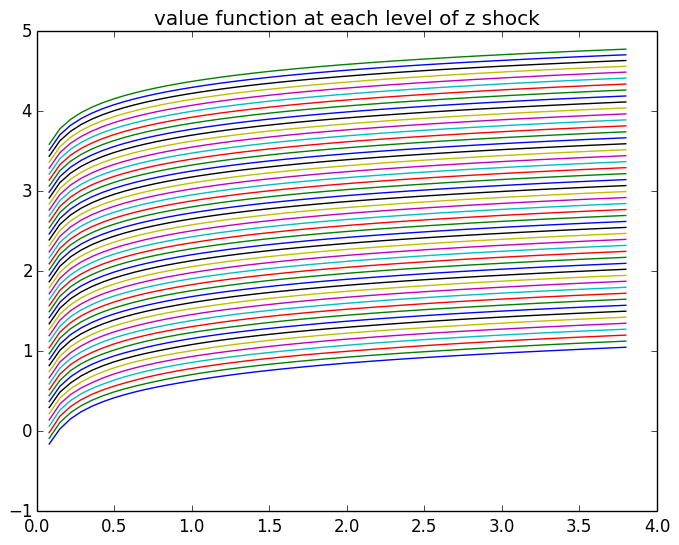

PyObject <matplotlib.text.Text object at 0x31849f910>

In [5]:
# plot value function
plot(kgrid,V1);
title("value function at each level of z shock")

* Plot the Policy function for each level of z

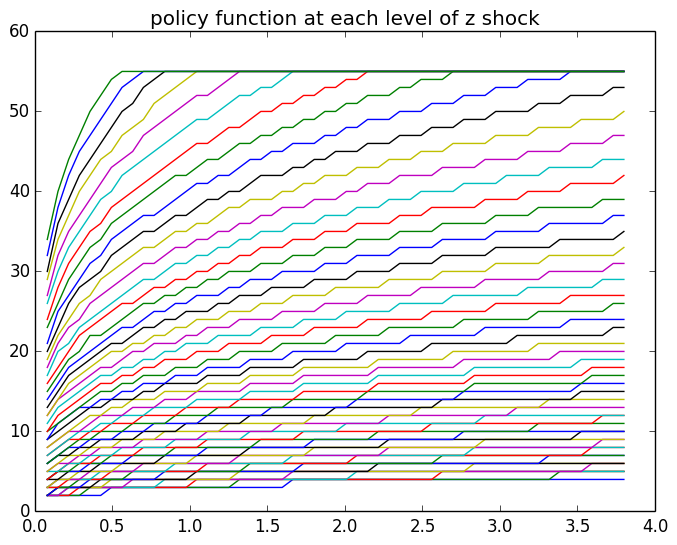

PyObject <matplotlib.text.Text object at 0x318a26390>

In [6]:
plot(kgrid,P);
title("policy function at each level of z shock")
# notice how ragged this looks. this is a consequence of our choice to discretize the state space. 

* can you comment on the shape of those policy functions? Do the *true* policy functions look like that?
* For $z=z_1$ plot the true and our approximate policy function in the same plot. Notice that our policy function gives the *index* of the optimal capital choice, not the level. So, in order to plot optimal capital, you need to pick the corresponding values from $\mathcal{K}$, as in `optimal_k = kgrid[P[:,1]]`.

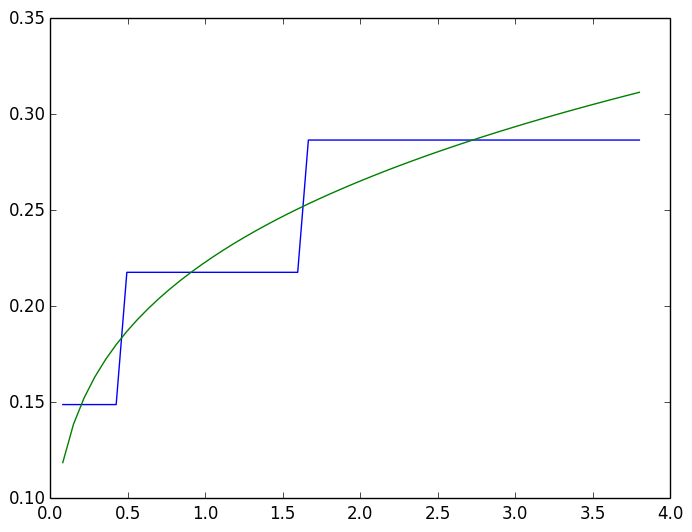

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x319a37290>
 PyObject <matplotlib.lines.Line2D object at 0x319a37510>

In [16]:
# choose z = 1
plot(kgrid,hcat(kgrid[P[:,1]],exp(zgrid[1])*kgrid.^alpha))

## Transition Function

* The policy function together with the distribution of $z$ determines a transition function of the state space from  $(k_i,z_j)$ to $(k_l,z_m)$. We need to compute the probability that given $(k_i,z_j)$, what is the probability that we end up in state $(k_l,z_m)$ tomorrow. This is easiest accomplished with a 4D array, where the first two dimensions are for $(k_i,z_j)$, and the last two for $(k_l,z_m)$. Each entry gives the probability of going into that state.
* Try to compute this transition function. you must fill this 4D array: `I = zeros(n,m,n,m)`. At each position in that array you want to combine 
    - the optimal choice $P(k,z)$ with 
    - the probability of going to next period's $z$, i.e. $\mathbf{q}$
    - you want some code that expresses *if the optimal index of k' is kprime, what's the probability of that and a  zshock of level zprime*

In [4]:
# traditional
I = zeros(n,m,n,m)
for i in 1:n
    for j in 1:m
        for kprime in 1:n
            for zprime in 1:m
                I[i,j,kprime,zprime] = (P[i,j]==kprime) * q[zprime]
            end
        end
    end
end

# julia comprehension
I= [ (P[i,j]==kprime) * q[zprime] for i=1:n, j=1:m, kprime=1:n, zprime=1:m];


* We want an *invariant* transition function. In order to find this, we can iterate on `Pi`. The idea is that 

In [6]:
pi = reshape(I,n*m,n*m);
Pi0 = pi;
for i=2:100
    Pi1 = pi * Pi0
    if maxabs(Pi1.-Pi0) < tol
        println("found invariant distribution")
        break
    end
    Pi0 = Pi1
end
    

LoadError: LoadError: InterruptException:
while loading In[6], in expression starting on line 3